In [1]:
# Libraries for data manipulation and visualization
# datafile path: /content/Customer_Profile_Data.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for dimension reduction and clustering analysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Library for displaying image
from IPython.display import display
from PIL import Image
#import dataframe_image as dfi
import cv2

In [2]:
# Import data
data_original = pd.read_csv(r"/content/Customer_Profile_Data.csv")

In [3]:
# Remove leading and trailing whitespace from column names
data_original.columns = data_original.columns.str.strip()

# Replace spaces with underscores and convert to lowercase
data_original.columns = data_original.columns.str.replace(' ', '_').str.lower()

# Rename columns
data_original.rename(columns = {'purchase_frequency_(past_6_months)': 'purchase_frequency',
                   'customer_lifetime_value_(clv)': 'customer_lifetime_value',
                    'nps_score': 'net_promoter_score'}, inplace = True)

In [4]:
# Check for duplicate rows in the entire DataFrame
duplicate_rows = data_original[data_original.duplicated()]
print(f"Number of Duplicate Rows: {duplicate_rows.shape[0]}")

Number of Duplicate Rows: 0


In [5]:
# Determine missing value counts
missing_data = data_original.isna().sum()
missing_percentage = round((missing_data / len(data_original)) * 100, 2)
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage': missing_percentage})
print(missing_info)

                              Missing Count  Missing Percentage
customer_id                               0                 0.0
age                                       0                 0.0
gender                                    0                 0.0
location                                  0                 0.0
income                                    0                 0.0
marital_status                            0                 0.0
purchase_frequency                        0                 0.0
average_order_value                       0                 0.0
preferred_product_categories              0                 0.0
last_purchase_date                        0                 0.0
return_rate                               0                 0.0
customer_lifetime_value                   0                 0.0
average_star_rating                       0                 0.0
net_promoter_score                        0                 0.0


In [6]:
# A function designed to clean a designated column in a DataFrame.
def clean_column(data, column_name, convert_to_float = True):
# Convert the column to string
    data[column_name] = data[column_name].astype(str)

    # Remove commas from the string
    data[column_name] = data[column_name].str.replace(',', '')

    # Remove leading and trailing whitespaces from the string
    data[column_name] = data[column_name].str.strip()

    # If specified, convert the column to float
    if convert_to_float:
        data[column_name] = data[column_name].astype(float)

In [7]:
# Clean selected columns
data_cleaned = data_original.copy()
clean_column(data_cleaned, 'income')
clean_column(data_cleaned, 'customer_lifetime_value')
clean_column(data_cleaned, 'average_order_value')

In [38]:
# Converting the 'return_rate' column to numeric format, followed by the creation of a dummy variable for return status.
data_cleaned['return_rate'] = pd.to_numeric(data_cleaned['return_rate'].astype(str).str.rstrip('%'),
                                             errors='coerce') / 100
# Convert 'last_purchase_date' to datetime format
data_cleaned['last_purchase_date'] = pd.to_datetime(data_cleaned['last_purchase_date'])

In [9]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   1029 non-null   object        
 1   age                           1029 non-null   int64         
 2   gender                        1029 non-null   object        
 3   location                      1029 non-null   object        
 4   income                        1029 non-null   float64       
 5   marital_status                1029 non-null   object        
 6   purchase_frequency            1029 non-null   int64         
 7   average_order_value           1029 non-null   float64       
 8   preferred_product_categories  1029 non-null   object        
 9   last_purchase_date            1029 non-null   datetime64[ns]
 10  return_rate                   1029 non-null   float64       
 11  customer_lifetime_value       

In [10]:
data_cleaned.describe(include=['int64', 'float64']).T

,count,mean,std,min,25%,50%,75%,max
age,1029.0,38.811467,12.610809,18.00,28.00,38.00,50.00,60.00
income,1029.0,177589.893100,76088.872206,50000.00,110000.00,180000.00,240000.00,300000.00
purchase_frequency,1029.0,2.513120,1.582084,1.00,1.00,2.00,3.00,7.00
average_order_value,1029.0,81895.153547,69091.834413,300.00,25000.00,64000.00,123000.00,299000.00
return_rate,1029.0,0.009009,0.023218,0.00,0.00,0.00,0.00,0.10
customer_lifetime_value,1029.0,680656.982507,977001.563635,450.00,88000.00,288000.00,860000.00,6984000.00
average_star_rating,1029.0,5.506900,1.360912,0.80,4.70,5.60,6.50,9.80
net_promoter_score,1029.0,62.096579,12.577375,9.86,55.45,63.27,70.92,97.37


In [11]:
# After comparing the mean and median of each feature, certain features exhibited skewness
from scipy.stats import skew, skewtest

# Specifying the column names for which we want to test skewness
numerical_columns = data_cleaned.select_dtypes(include = ['number']).columns.tolist()
columns_to_test = numerical_columns

# Create a dictionary to store skewness, p-value, and log-transform decision for each column
results_dict = {'Feature Name': [], 'Skewness': [], 'p-value': [], 'Transform Needed': []}

for column in columns_to_test:
    # Calculate skewness
    skewness_value = skew(data_cleaned[column])

    # Perform skewness test
    stat, p_value = skewtest(data_cleaned[column])

    # Log-Transform decision based on p-value
    transform = 'Yes' if (abs(skewness_value) >= 1) & (p_value < 0.05) else 'No'

    # Store results in the dictionary
    results_dict['Feature Name'].append(column)
    results_dict['Skewness'].append(skewness_value)
    results_dict['p-value'].append(p_value)
    results_dict['Transform Needed'].append(transform)

# Create a DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Format the p-value column
results_df['p-value'] = results_df['p-value'].apply(lambda x: format(x, '.4f'))

results_df

,Feature Name,Skewness,p-value,Transform Needed
0,age,0.015997,0.8329,No
1,income,-0.012181,0.8724,No
2,purchase_frequency,0.969835,0.0000,No
3,average_order_value,0.871546,0.0000,No
4,return_rate,2.651636,0.0000,Yes
5,customer_lifetime_value,2.717619,0.0000,Yes
6,average_star_rating,-0.387746,0.0000,No
7,net_promoter_score,-0.736679,0.0000,No


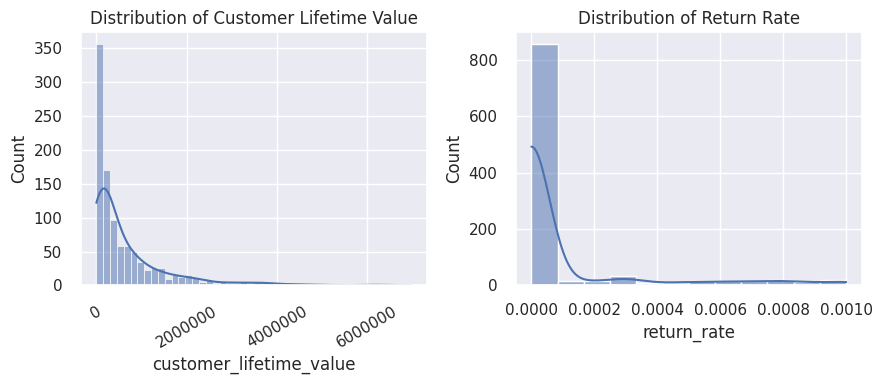

In [44]:
# Addresing Skewed Features
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.set(style='darkgrid')

# Plot 1
sns.histplot(data_cleaned['customer_lifetime_value'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Customer Lifetime Value')
axes[0].ticklabel_format(style='plain', axis='x')  # Disable scientific notation for x-axis ticks
axes[0].tick_params(axis='x', rotation=30)  # Rotate x-tick labels for the first plot

# Plot 2
sns.histplot(data_cleaned['return_rate'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Return Rate')

plt.tight_layout()
plt.show()

In [41]:
# The above plots indicate a strong right skew in both features, prompting the use of a log transformation to reduce the skewness.
data_cleaned['customer_lifetime_value_log'] = np.log1p(data_cleaned['customer_lifetime_value'])
data_cleaned['return_rate_log'] = np.log1p(data_cleaned['return_rate'])

In [40]:
# The following shows the results after transformation:
print('Skewness after log-transformation:')
print('customer_lifetime_value: {:.6f}'.format(skew(data_cleaned['customer_lifetime_value_log'])))
print('return_rate: {:.6f}'.format(skew(data_cleaned['return_rate_log'])))

Skewness after log-transformation:
customer_lifetime_value: -0.676294
return_rate: 2.622120


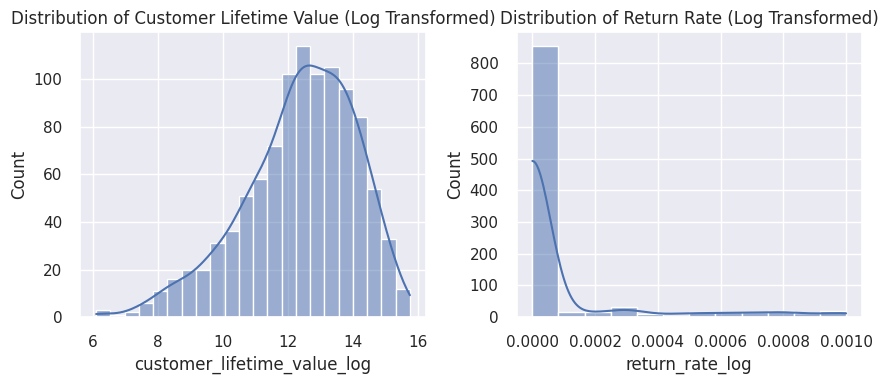

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))
sns.set(style = 'darkgrid')

# Plot 1
sns.histplot(data_cleaned['customer_lifetime_value_log'], kde = True, ax = axes[0])
axes[0].set_title('Distribution of Customer Lifetime Value (Log Transformed)')
axes[0].ticklabel_format(style='plain', axis='x')  # Disable scientific notation for x-axis ticks

# Plot 2
sns.histplot(data_cleaned['return_rate_log'], kde = True, ax = axes[1])
axes[1].set_title('Distribution of Return Rate (Log Transformed)')

plt.tight_layout()
plt.show()

In [16]:
# Convert "return_rate" into binary variable
data_cleaned['return_occurred'] = (data_cleaned['return_rate'] > 0).astype(bool)
data_cleaned['return_occurred'].value_counts()

,count
return_occurred,
False,855
True,174


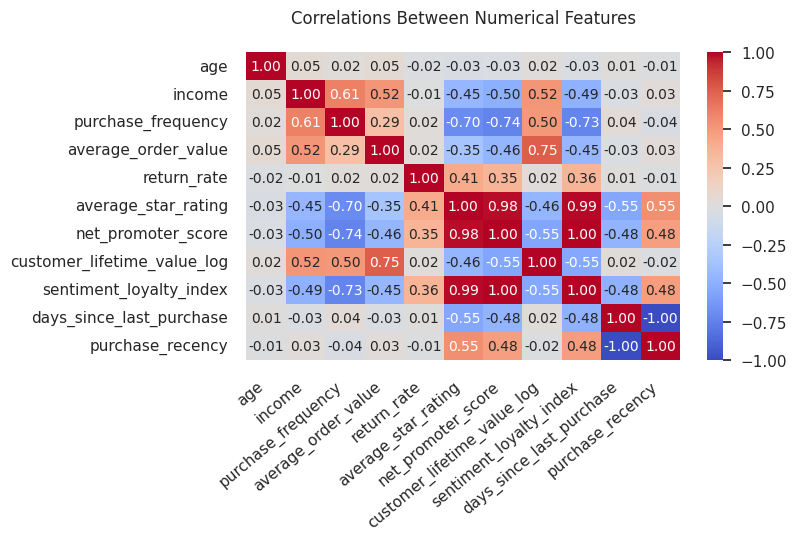

In [42]:
# Correlations Between Numerical Features via a correlation matrix.
correlation_matrix = data_cleaned.drop(
    columns = ['return_rate_log', 'customer_lifetime_value']).select_dtypes(include = ['number']).corr()

# Visualize the correlation matrix
plt.figure(figsize = (7, 4))
g = sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", annot_kws={"size": 10})
g.set_xticklabels(g.get_xticklabels(), rotation = 40, va = 'top', ha = 'right')
plt.title('Correlations Between Numerical Features\n')
plt.show()

In [18]:
data_cleaned['sentiment_loyalty_index'] = data_cleaned[['average_star_rating', 'net_promoter_score']].mean(axis = 1)

In [19]:
# Non-Numerical Features
data_cleaned.select_dtypes(exclude = ['number', 'bool']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   customer_id                   1029 non-null   object        
 1   gender                        1029 non-null   object        
 2   location                      1029 non-null   object        
 3   marital_status                1029 non-null   object        
 4   preferred_product_categories  1029 non-null   object        
 5   last_purchase_date            1029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 48.4+ KB


In [20]:
# Set the reference date
reference_date = pd.to_datetime('2024-01-02')

# Calculate time intervals in days
data_cleaned['days_since_last_purchase'] = (reference_date - data_cleaned['last_purchase_date']).dt.days

# Get descriptive statistics of the new feature
data_cleaned['days_since_last_purchase'].describe()

,days_since_last_purchase
count,1029.000000
mean,151.680272
std,87.328463
min,0.000000
25%,78.000000
50%,151.000000
75%,230.000000
max,299.000000


In [21]:
data_cleaned.select_dtypes(include = 'object').drop(columns = ['customer_id']).describe().T

,count,unique,top,freq
gender,1029,2,Male,547
location,1029,54,Philadelphia,46
marital_status,1029,2,Married,531
preferred_product_categories,1029,8,Necklace,226


In [22]:
# Feature Selection
# Convert "days_since_last_purchase" to "purchase_recency"
data_cleaned['purchase_recency'] = 300 - data_cleaned['days_since_last_purchase']

In [23]:
data_selected_features = data_cleaned[['purchase_frequency', 'purchase_recency',
                                          'average_order_value', 'customer_lifetime_value_log',
                                          'sentiment_loyalty_index']]
data_selected_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1029 entries, 0 to 1028
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   purchase_frequency           1029 non-null   int64  
 1   purchase_recency             1029 non-null   int64  
 2   average_order_value          1029 non-null   float64
 3   customer_lifetime_value_log  1029 non-null   float64
 4   sentiment_loyalty_index      1029 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 40.3 KB


In [37]:
# Feature Scaling
# Prior to clustering, the data undergoes a final preprocessing step: scaling.
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the numeric data and add "_std" to column names
data_clustering = scaler.fit_transform(data_selected_features)
data_clustering = pd.DataFrame(data_clustering,
                               columns = data_selected_features.columns + '_std')

data_clustering.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
purchase_frequency_std,1029.0000,0.0000,1.0000,-0.9570,-0.9570,-0.3240,0.3080,2.8370
purchase_recency_std,1029.0000,-0.0000,1.0000,-1.6880,-0.8970,0.0080,0.8440,1.7380
average_order_value_std,1029.0000,-0.0000,1.0000,-1.1820,-0.8240,-0.2590,0.5950,3.1440
customer_lifetime_value_log_std,1029.0000,0.0000,1.0000,-3.6420,-0.5810,0.1070,0.7420,1.9570
sentiment_loyalty_index_std,1029.0000,-0.0000,1.0000,-4.0650,-0.5290,0.0870,0.6990,2.8450


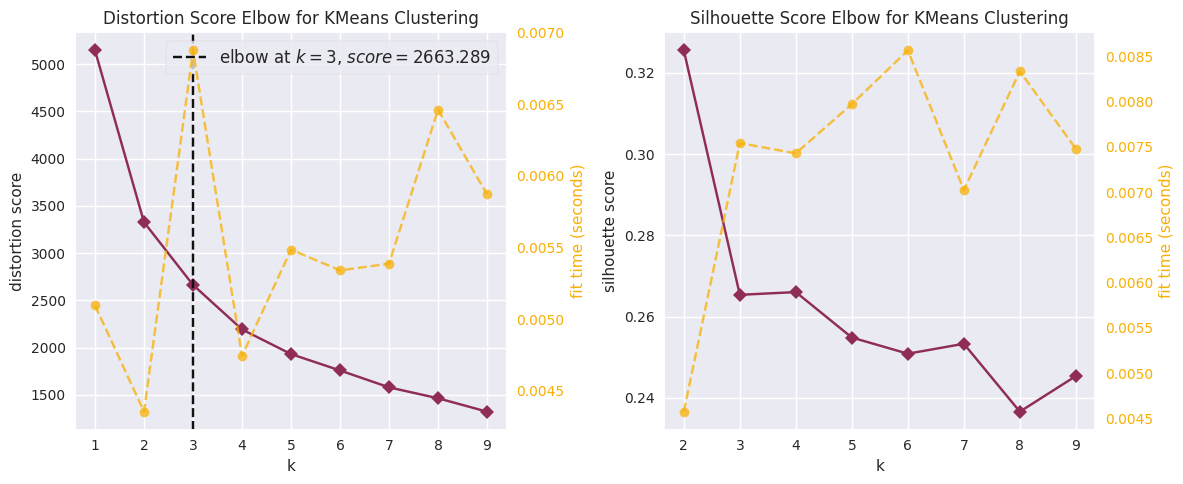

In [36]:
# Determining Optimal k
# We employ the Elbow method to determine the appropriate number of clusters.
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state = 43)

# Create subplots with 1 row and 2 columns, specifying the figsize
fig, axes = plt.subplots(ncols = 2, figsize = (12, 5))

# Visualizer for distortion score
visualizer_distortion = KElbowVisualizer(model, k = (1, 10), ax = axes[0])
visualizer_distortion.fit(data_clustering)
visualizer_distortion.finalize()

# Visualizer for silhouette score with an adjusted k range
visualizer_silhouette = KElbowVisualizer(model, k = (2, 10), metric = 'silhouette',
                                         ax = axes[1], locate_elbow = False)
visualizer_silhouette.fit(data_clustering)
visualizer_silhouette.finalize()

plt.tight_layout()
plt.show()

In [26]:
from sklearn.cluster import KMeans
# Use K-Means with Gower distances
kmeans = KMeans(n_clusters = 3, random_state = 43)
kmeans.fit(data_clustering)

# Assign cluster labels back to the DataFrame
data_clustering_results = data_clustering.copy()
data_clustering_results['cluster_labels_kmeans'] = kmeans.labels_

In [27]:
def generate_cluster_sizes_table(column_name, data=data_clustering_results):
    cluster_sizes = data[column_name].value_counts().sort_index()
    total_samples = len(data)

    cluster_sizes_table = pd.DataFrame({'Cluster': cluster_sizes.index + 1, 'Size': cluster_sizes.values})
    cluster_sizes_table['Percentage'] = (cluster_sizes_table['Size'] / total_samples) * 100

    return cluster_sizes_table

In [28]:
# Generate cluster sizes table of k-means clustering
generate_cluster_sizes_table('cluster_labels_kmeans')

,Cluster,Size,Percentage
0,1,403,39.164237
1,2,284,27.599611
2,3,342,33.236152


In [35]:
# Now visualizing these clusters in 2D PCA space
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=5)  # Set the desired number of components
principal_components = pca.fit_transform(data_clustering)

# Get the loadings (components_)
loadings = pca.components_

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings, columns=data_clustering.columns, index=[f'PC{i}' for i in range(1, 6)])

# Set pandas options for formatting
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Display the loadings
print("Principal Components Loadings:")
loadings_df.T

Principal Components Loadings:


,PC1,PC2,PC3,PC4,PC5
purchase_frequency_std,-0.4668,-0.0515,0.7069,-0.0036,0.5289
purchase_recency_std,0.1626,0.7917,0.4372,-0.1503,-0.3647
average_order_value_std,-0.4496,0.3956,-0.4930,-0.5570,0.2969
customer_lifetime_value_log_std,-0.5157,0.3092,-0.2165,0.7579,-0.1306
sentiment_loyalty_index_std,0.5362,0.3441,-0.1388,0.3044,0.6943


In [30]:
# A function to visualize clustering results in 2D PCA space
def visualize_clusters_2d(cluster_labels,
                          data = data_clustering_results,
                          title = 'Clustering Results'):

    if isinstance(cluster_labels, str):
        cluster_labels = [cluster_labels]

    # Apply PCA
    pca = PCA(n_components = 2)
    data_pca = pca.fit_transform(data.iloc[:, :5])

    plt.figure(figsize=(7, 5))
    sns.set_style("darkgrid")

    # Custom color palette
    palette = ["#8f2d56", "#f8b005", "#023047"]
    sns.set_palette(palette)

    for label in cluster_labels:
        # Create a DataFrame for visualization
        data_pca_with_labels = pd.DataFrame(data_pca, columns = ['PC1', 'PC2'])
        data_pca_with_labels[label] = data[label]

        ax = sns.scatterplot(x='PC1', y='PC2', hue=label, palette=palette, data=data_pca_with_labels, alpha=0.5)

    # Get legend handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Customize legend labels
    custom_labels = ['Cluster 1', 'Cluster 2', 'Cluster 3']
    ax.legend(handles, custom_labels)

    plt.title(title)
    plt.xlabel('Overall Customer Value (PC1)')
    plt.ylabel('Recency Emphasis (PC2)')

    plt.show()

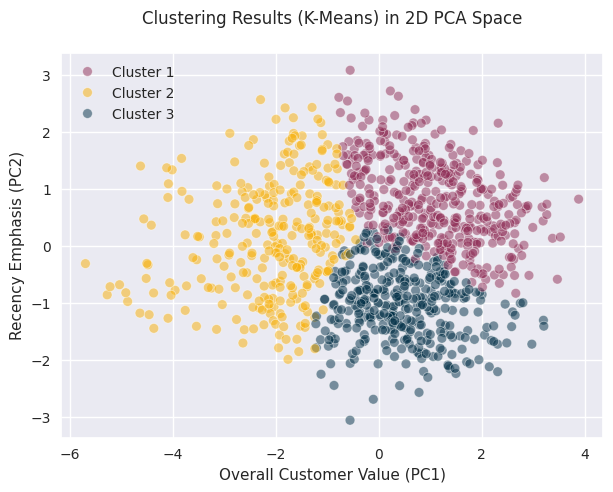

In [31]:
visualize_clusters_2d('cluster_labels_kmeans',
                      title = 'Clustering Results (K-Means) in 2D PCA Space\n')

In [32]:
# Profiling preparation
# Create cetroids table
#To gain a deeper comprehension of the k-means clusters, examining the centroids of each cluster provides valuable insights.
centroids = kmeans.cluster_centers_
centroids_df = pd.DataFrame(centroids, columns = data_clustering.columns)
centroids_df.index = ['cluster 1', 'cluster 2', 'cluster 3']

centroids_df.T

,cluster 1,cluster 2,cluster 3
purchase_frequency_std,-0.4877,1.1028,-0.3411
purchase_recency_std,0.8480,-0.1441,-0.8796
average_order_value_std,-0.2268,0.9654,-0.5344
customer_lifetime_value_log_std,-0.3246,1.0203,-0.4648
sentiment_loyalty_index_std,0.8453,-1.1191,-0.0668


In [33]:
# The Parallel Coordinate Plot
from pandas.plotting import parallel_coordinates
import matplotlib.patches as mpatches

def visualize_parallel_coordinates(cluster_label_column,
                                   data_clustering_results = data_clustering_results,
                                   title = ''):
    """
    Visualizes clustering results with parallel coordinates and centroids.

    Parameters:
    - cluster_label_column (str): The column name containing cluster labels.
    - data_clustering_results (pd.DataFrame): The input data with clustering results.
    - title (str): Title for the plot. Default is an empty string.

    Returns:
    - None: Displays the parallel coordinates plot with centroids.
    """
    # Plot the parallel coordinates with the reordered features
    plt.figure(figsize=(11, 7))
    sns.set_style("darkgrid")

    # Define custom colors for each cluster
    custom_colors = ["#8f2d56", "#f8b005", "#023047"]

    # Plot the parallel coordinates with the reordered features
    data_parallel_coordinates = pd.concat([data_clustering_results.iloc[:, :5],
                                           data_clustering_results[cluster_label_column]],
                                           axis=1)

    ax = parallel_coordinates(data_parallel_coordinates, cluster_label_column,
                               color=custom_colors, alpha=0.3)

    # Set custom x-axis labels
    custom_x_labels = ['purchase\nfrequency', 'purchase\nrecency',
                       'average\norder value', 'customer\nlifetime value',
                       'sentiment-loyalty\n index']
    plt.xticks(range(len(custom_x_labels)), custom_x_labels, fontsize=14, ha='center')

    # Set fontsize for y ticks
    plt.yticks(fontsize=16)

    # Get unique cluster labels
    unique_labels = data_parallel_coordinates[cluster_label_column].unique()

    # Create custom legend patches
    legend_patches = [mpatches.Patch(color=custom_colors[label], label=f'Cluster {label + 1}') for label in unique_labels]

    # Add legend
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(0.85, 1))

    # Highlight cluster centroids
    centroids = data_parallel_coordinates.groupby(cluster_label_column).mean().reset_index()
    for i, centroid in centroids.iterrows():
        ax.plot(range(len(custom_x_labels)), centroid[1:], color=custom_colors[i], linewidth=6)
        plt.plot(range(len(custom_x_labels)), centroid[1:], color='black', linewidth=4, alpha=0.7)

    plt.title(title, fontsize=16)
    plt.show()

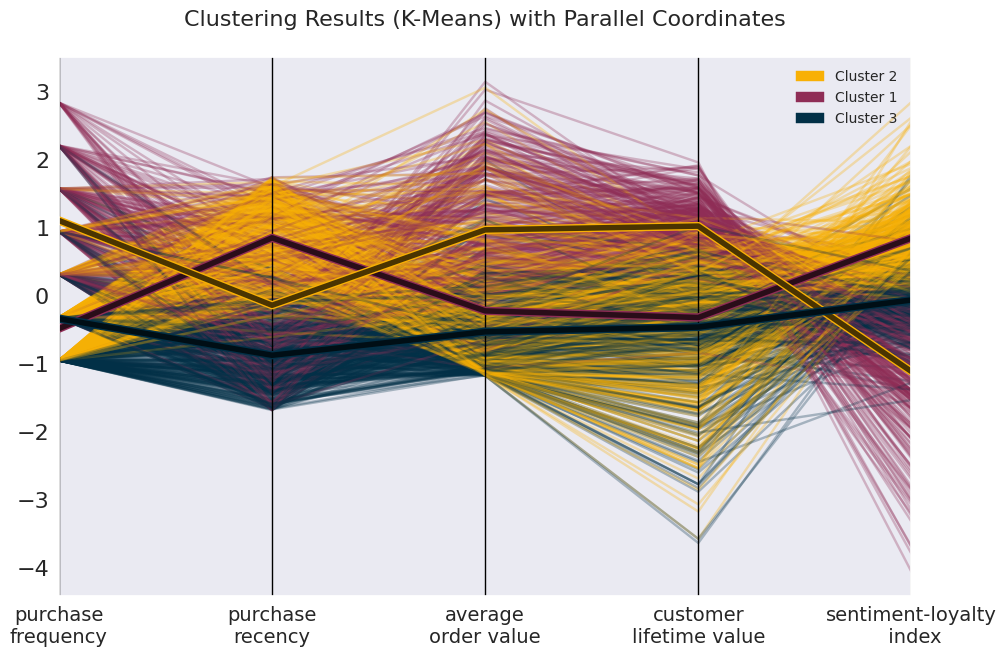

In [34]:
# The different behavioral patterns of each cluster can be visualized with the following parallel coordinate plot.
visualize_parallel_coordinates('cluster_labels_kmeans',
                               title = 'Clustering Results (K-Means) with Parallel Coordinates\n')